<a href="https://colab.research.google.com/github/lorrespz/NLP-Text-Analyses/blob/main/Spam_detection_with_custom_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam detection with custom LSTM

This notebook is from Lazy Programmer's PyTorch course. In this notebook, everything is built custom (all text processing steps are done manually, including tokenizing (breaking up sentences into word tokens), converting each token into integers, and building a data generator for batch training).

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Get and load data

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2024-03-09 07:31:55--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.1s    

2024-03-09 07:31:55 (3.72 MB/s) - ‘spam.csv’ saved [503663/503663]



In [3]:
df = pd.read_csv('spam.csv', encoding = 'ISO-8859-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [7]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

In [9]:
# Rename columns
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
# Create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam':1})

In [12]:
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [13]:
# TRAIN-TEST-SPLIT
df_train, df_test = train_test_split(df, test_size = 0.33)
df_train.shape, df_test.shape

((3733, 3), (1839, 3))

# Text processing: Tokenization

In [14]:
# FIRST STEP: TOKENIZE AND CREATE A DICTIONARY TO CONVERT WORDS TO INTEGERS
idx = 1
word2idx = {'<PAD>' : 0}

for i, row in df_train.iterrows():
  tokens = row['data'].lower().split() #this is the tokenizing step
  #now convert the tokens to integers
  for token in tokens:
    if token not in word2idx:
      word2idx[token] = idx
      idx +=1

In [15]:
word2idx

{'<PAD>': 0,
 'whore': 1,
 'you': 2,
 'are': 3,
 'unbelievable.': 4,
 'block': 5,
 'breaker': 6,
 'now': 7,
 'comes': 8,
 'in': 9,
 'deluxe': 10,
 'format': 11,
 'with': 12,
 'new': 13,
 'features': 14,
 'and': 15,
 'great': 16,
 'graphics': 17,
 'from': 18,
 't-mobile.': 19,
 'buy': 20,
 'for': 21,
 'just': 22,
 'å£5': 23,
 'by': 24,
 'replying': 25,
 'get': 26,
 'bbdeluxe': 27,
 'take': 28,
 'the': 29,
 'challenge': 30,
 '&lt;#&gt;': 31,
 '%of': 32,
 'pple': 33,
 'marry': 34,
 'their': 35,
 'lovers...': 36,
 'becz': 37,
 'they': 38,
 'hav': 39,
 'gud': 40,
 'undrstndng': 41,
 'dat': 42,
 'avoids': 43,
 'problems.': 44,
 'i': 45,
 'sent': 46,
 'dis': 47,
 '2': 48,
 'u,': 49,
 'u': 50,
 'wil': 51,
 'news': 52,
 'on': 53,
 'friday': 54,
 'd': 55,
 'person': 56,
 'like.': 57,
 'tomorrow': 58,
 'will': 59,
 'be': 60,
 'best': 61,
 'day': 62,
 'of': 63,
 'your': 64,
 'life.': 65,
 'dont': 66,
 'break': 67,
 'this': 68,
 'chain.': 69,
 'if': 70,
 'suffer.': 71,
 'send': 72,
 'to': 73,
 'frn

In [16]:
len(word2idx)

10462

In [19]:
# TOKENIZE THE TRAIN AND TEST SETS:
#this step could have been done above, but for pedagogical purpose, do it separately

#TRAIN SET
train_sentences_as_int = []
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens]
  train_sentences_as_int.append(sentence_as_int)

#TEST SET
test_sentences_as_int = []
for i, row in df_test.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens if token in word2idx]
  test_sentences_as_int.append(sentence_as_int)

In [23]:
len(train_sentences_as_int), len(test_sentences_as_int)

(3733, 1839)

In [29]:
train_sentences_as_int[0], test_sentences_as_int[10]

([1, 2, 3, 4], [475, 2, 2145, 103, 604, 159, 68])

# Custom data generator for batch training

In [30]:
def data_generator(X, y, bs = 32):
  X, y = shuffle(X, y)
  n_batches = int(np.ceil(len(y))/bs)
  for i in range(n_batches):
    #this is to account for the last batch
    #which may not be a full size batch
    end = min((i+1)*bs, len(y))

    X_batch = X[i*bs:end]
    y_batch = y[i*bs:end]

    #pad X_batch to be NxT
    max_len = np.max([len(x) for x in X_batch])
    for j in range(len(X_batch)):
      x = X_batch[j]
      pad = [0]*(max_len - len(x))
      X_batch[j] = pad + x

    #convert to tensor
    X_batch = torch.from_numpy(np.array(X_batch))
    y_batch = torch.from_numpy(np.array(y_batch))
    #do not use 'return' since this is a data generator
    yield X_batch, y_batch

In [40]:
for inputs, targets in data_generator(train_sentences_as_int, df_train.b_labels):
  print('INPUTS:' 'shape:', inputs.shape, '\n inputs:', inputs)
  print('TARGETS:' 'shape:', targets.shape, '\n targets:', targets)
  break

INPUTS:shape: torch.Size([32, 54]) 
 inputs: tensor([[    0,     0,     0,  ...,  2580,   967,   548],
        [    0,     0,     0,  ...,   986,    62,   145],
        [    0,     0,     0,  ...,  2573,    53,  6440],
        ...,
        [    0,     0,     0,  ...,   149,   429,   444],
        [    0,     0,     0,  ...,  3869,    21,  7400],
        [    0,     0,     0,  ..., 10420,   526,   528]])
TARGETS:shape: torch.Size([32]) 
 targets: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0])


In [41]:
for inputs, targets in data_generator(test_sentences_as_int, df_test.b_labels):
  print('INPUTS:' 'shape:', inputs.shape, '\n inputs:', inputs)
  print('TARGETS:' 'shape:', targets.shape, '\n targets:', targets)
  break

INPUTS:shape: torch.Size([32, 32]) 
 inputs: tensor([[   0,    0,    0,  ...,    2,  103, 9636],
        [   0,    0,    0,  ..., 7739, 6292, 6292],
        [   0,    0,    0,  ..., 6906,  139,  191],
        ...,
        [   0,    0,    0,  ...,   68, 1268, 1170],
        [   0,    0,    0,  ...,  492,   78,   81],
        [   0,    0,    0,  ..., 1645, 1646, 1647]])
TARGETS:shape: torch.Size([32]) 
 targets: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1])


 # Define the custom LSTM model

 Recall that the main task of language processing lies in identifying the relationship between words - this is mathematically realized by finding the Euclidean distance between a pair of words which have been encoded as vectors. So, a crucial part of NLP is the embedding of integers representing words into 'word vectors'. This is the main idea of 'embedding'. Pretrained embeddings exist like 'word2vec' and 'GloVe' which have predetermined weights encoding the Euclidean distance between words.

In [42]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [54]:
class LSTM(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
    super(LSTM, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    #output is VxD
    self.embed = nn.Embedding(self.V, self.D)
    #output is DxM
    self.rnn = nn.LSTM(input_size = self.D,
                       hidden_size = self.M,
                       num_layers = self.L,
                       batch_first = True)
    #output is MxK
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    #input X is of size NxT where T is a sequence of integers
    #initialize the hidden and cell states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    #Embedding layer: turns word indexes to word vectors
    #output is NxTxD
    out = self.embed(X)

    #Get LSTM unit output
    #output is NxTxM
    out, _ = self.rnn(out, (h0,c0))

    #global max pool: collapses the T dimension
    # gives an output NxM
    out, _ = torch.max(out, 1)

    #output is NxK
    out = self.fc(out)

    return out



In [55]:
model = LSTM(n_vocab=len(word2idx), embed_dim = 20, n_hidden=15, n_rnnlayers=1, n_outputs=1)
model.to(device)

LSTM(
  (embed): Embedding(10462, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [56]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())


# Train and test

In [50]:
train_gen = lambda: data_generator(train_sentences_as_int, df_train.b_labels)
test_gen = lambda: data_generator(test_sentences_as_int, df_test.b_labels)

In [51]:
train_gen

<function __main__.<lambda>()>

In [52]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for i in range(epochs):
    t0 = datetime.now()
    #TRAIN SET
    train_loss = []
    for inputs, targets in train_gen():
      targets = targets.view(-1,1).float()
      inputs, targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    train_losses[i] = train_loss

    #TEST SET
    test_loss = []
    for inputs, targets in test_gen():
      targets = targets.view(-1,1).float()
      inputs, targets = inputs.to(device), targets.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      test_loss.append(loss.item())

    test_loss = np.mean(test_loss)
    test_losses[i] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {i}/{epochs}, train loss: {train_losses[i]: .4f}, \
            test loss: {test_losses[i]: .4f}, duration: {dt}')

  return train_losses, test_losses

In [57]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, 15)

Epoch 0/15, train loss:  0.5144,             test loss:  0.3811, duration: 0:00:01.638257
Epoch 1/15, train loss:  0.3178,             test loss:  0.2799, duration: 0:00:01.464377
Epoch 2/15, train loss:  0.2298,             test loss:  0.2180, duration: 0:00:01.539593
Epoch 3/15, train loss:  0.1703,             test loss:  0.1846, duration: 0:00:01.251828
Epoch 4/15, train loss:  0.1291,             test loss:  0.1558, duration: 0:00:01.240145
Epoch 5/15, train loss:  0.1004,             test loss:  0.1406, duration: 0:00:01.441084
Epoch 6/15, train loss:  0.0792,             test loss:  0.1271, duration: 0:00:01.306710
Epoch 7/15, train loss:  0.0666,             test loss:  0.1233, duration: 0:00:02.451587
Epoch 8/15, train loss:  0.0573,             test loss:  0.1169, duration: 0:00:02.548911
Epoch 9/15, train loss:  0.0511,             test loss:  0.1122, duration: 0:00:03.693809
Epoch 10/15, train loss:  0.0453,             test loss:  0.1078, duration: 0:00:03.415899
Epoch 11/

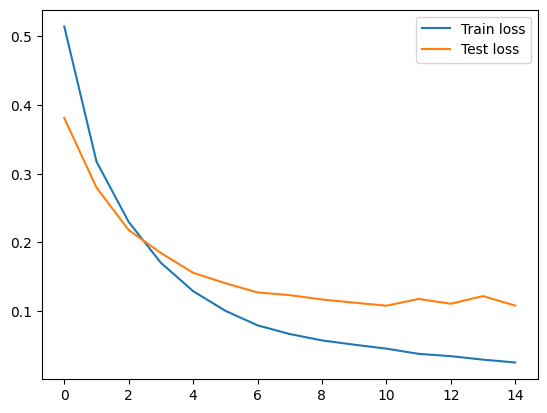

In [58]:
plt.plot(train_losses, label = 'Train loss')
plt.plot(test_losses, label = 'Test loss')
plt.legend()
plt.show()

# Calculate model accuracy

In [60]:
n_correct = 0
n_total = 0
for inputs, targets in train_gen():
  targets = targets.view(-1,1).float()
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  predictions = (outputs >0)
  n_correct +=(predictions == targets).sum().item()
  n_total+=targets.shape[0]

train_acc = n_correct/n_total

#TEST SET
for inputs, targets in test_gen():
  targets = targets.view(-1,1).float()
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  predictions = (outputs >0)
  n_correct +=(predictions == targets).sum().item()
  n_total+=targets.shape[0]

test_acc = n_correct/n_total

print(f'Train accuracy: {train_acc}, Test accuracy: {test_acc}')

Train accuracy: 0.9962284482758621, Test accuracy: 0.9868135838150289
